In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

ticker = 'MSFT'
ticker_data = yf.Ticker(ticker)

data = ticker_data.history(period="max")
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055121,0.063227,0.055121,0.060524,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060524,0.063767,0.060524,0.062686,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062686,0.064307,0.062686,0.063767,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063767,0.064307,0.061605,0.062145,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062145,0.062686,0.060524,0.061065,47894400,0.0,0.0


In [3]:
hist= data.copy(deep=True)

<Axes: xlabel='Date'>

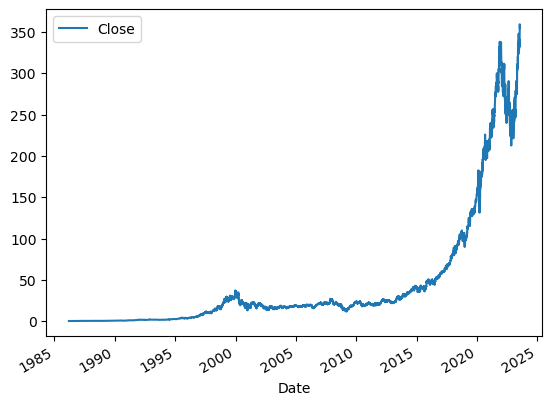

In [4]:
hist.plot.line(y="Close", use_index=True)

In [90]:
del hist["Dividends"]
del hist["Stock Splits"]

In [5]:
hist["Tomorrow"] = hist["Close"].shift(-1)
hist["Target"] = (hist["Tomorrow"] > hist["Close"]).astype(int)

In [6]:
hist = hist.loc["2000-01-01":].copy()

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

target = 'Target'
predictors = ["Close", "Volume", "Open", "High", "Low"]

train = hist.iloc[:-100]
test = hist.iloc[-100:]

model.fit(train[predictors], train[target])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [8]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5897435897435898

In [9]:
def predict(train, test, predictors, target, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [10]:
def backtest(data, model, predictors, taget, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors,target, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [11]:
predictions = backtest(hist, model, predictors, target)

In [12]:
predictions["Predictions"].value_counts()

0    2138
1    1285
Name: Predictions, dtype: int64

prediction says that 1200 times the price would increase

In [13]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5198443579766537

In [14]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.521472
0    0.478528
Name: Target, dtype: float64

In [16]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(predictions["Target"], predictions["Predictions"])
precision = precision_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.3742296918767507 
Precision: 0.5198443579766537 
Accuracy: 0.4934268185801928 
F1: 0.43517915309446253


Recall: how many actually possitive cases were correctly identified TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

In [18]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])

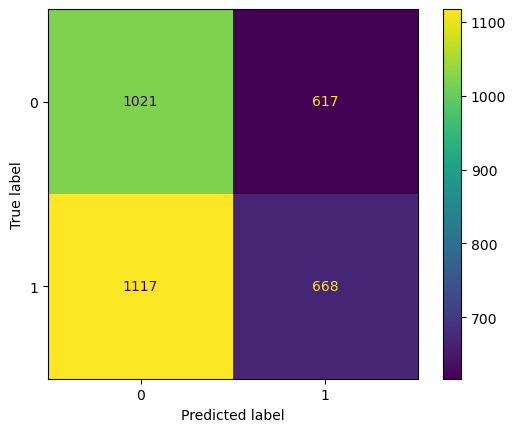

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

Model correctly identified price not increasing the following day 1012 times (TP) and correctly identified price INcreasing the following day 672 times (TN). The FN case - The Price increased while model predicted a decrease 1109 times (almost the same as TP and FP - 625. 

Lets crate new predictors

In [20]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = hist.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    hist[ratio_column] = hist["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    hist[trend_column] = hist.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [21]:
hist = hist.dropna()

In [22]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,16.988565,17.114174,16.957164,17.089052,12076900,0.0,0.0,17.246058,1,1.003134,1.0,1.000810,1.0,1.010061,31.0,1.048220,129.0,0.894303,489.0
2003-12-29 00:00:00-05:00,17.089047,17.290022,17.057645,17.246058,40426700,0.0,0.0,17.283735,1,1.004573,2.0,1.009262,2.0,1.019896,32.0,1.057552,130.0,0.903361,490.0
2003-12-30 00:00:00-05:00,17.214650,17.302576,17.208370,17.283735,34406600,0.0,0.0,17.189531,0,1.001091,2.0,1.008945,3.0,1.023010,32.0,1.059716,130.0,0.906196,490.0
2003-12-31 00:00:00-05:00,17.220933,17.302578,17.101605,17.189531,42198900,0.0,0.0,17.239777,1,0.997267,1.0,1.001830,3.0,1.018480,31.0,1.053825,129.0,0.902063,490.0
2004-01-02 00:00:00-05:00,17.321422,17.440750,17.164411,17.239777,44487700,0.0,0.0,17.673119,1,1.001459,1.0,1.001752,4.0,1.022425,32.0,1.056855,129.0,0.905529,490.0


In [23]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [27]:
def predict(train, test, predictors, target, model, thrsh = 0.6):
    #0.6 probability threshold so that we have a better confidence that price will increase
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1] #predicts probability
    preds[preds >=thrsh] = 1
    preds[preds <thrsh] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

In [28]:
target = 'Target'
#predictors = predictors + new_predictors
predictors = new_predictors + ["Close", "Volume"] #the other prices tell us little about the prediction 
print('Predictors:')
print(predictors)
predictions = backtest(hist, model, predictors, target)

Predictors:
['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000', 'Close', 'Volume']


In [29]:
predictions["Predictions"].value_counts()

0.0    2221
1.0     201
Name: Predictions, dtype: int64

So now we only predict 200 days when price will increase in contrary to rpevious results where it was 1200

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5024875621890548

In [31]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.529315
0    0.470685
Name: Target, dtype: float64

In [32]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(predictions["Target"], predictions["Predictions"])
cf_matrix

array([[1040,  100],
       [1181,  101]], dtype=int64)

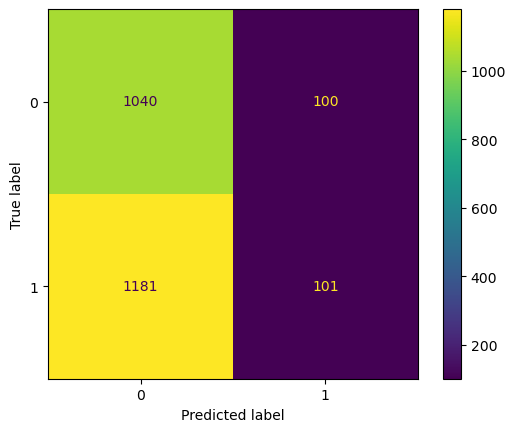

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

In [34]:
recall = recall_score(predictions["Target"], predictions["Predictions"])
precision = precision_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
f1 = f1_score(predictions["Target"], predictions["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.07878315132605304 
Precision: 0.5024875621890548 
Accuracy: 0.47109826589595377 
F1: 0.13621038435603505
